NAME- ADARSH SAGAR

Small Scale Validation/Code Implementation for AI Powered Inventory Management System For Smart Retail Optimization-

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Loading the dataset-

In [37]:
df = pd.read_csv("/content/synthetic_inventory_data.csv")

In [38]:
df.head()

,Date,Product,Stock_Levels,Sales_Volume,Price,Demand_Forecast
0,2023-01-01,Product_1,138,14,81.69,14
1,2023-01-02,Product_1,131,7,81.69,9
2,2023-01-03,Product_1,125,6,81.69,5
3,2023-01-04,Product_1,107,18,81.69,18
4,2023-01-05,Product_1,97,10,81.69,12


In [39]:
df.groupby('Product').count()

,Date,Stock_Levels,Sales_Volume,Price,Demand_Forecast
Product,,,,,
Product_1,365,365,365,365,365
Product_10,365,365,365,365,365
Product_2,365,365,365,365,365
Product_3,365,365,365,365,365
Product_4,365,365,365,365,365
Product_5,365,365,365,365,365
Product_6,365,365,365,365,365
Product_7,365,365,365,365,365
Product_8,365,365,365,365,365


In [40]:
# Reducing the number of product types to 3-
top_3_products = df['Product'].value_counts().nlargest(3).index
df= df[df['Product'].isin(top_3_products)]

# Now df_filtered contains only the top 3 product types-
print(df.head())

         Date    Product  Stock_Levels  Sales_Volume  Price  Demand_Forecast
0  2023-01-01  Product_1           138            14  81.69               14
1  2023-01-02  Product_1           131             7  81.69                9
2  2023-01-03  Product_1           125             6  81.69                5
3  2023-01-04  Product_1           107            18  81.69               18
4  2023-01-05  Product_1            97            10  81.69               12


# Data Preprocessing-

In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Product', 'Date'], inplace=True)

<ipython-input-41-fa4298a33d48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-41-fa4298a33d48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['Product', 'Date'], inplace=True)


In [42]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Product', 'Date'], inplace=True)

<ipython-input-42-fa4298a33d48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-42-fa4298a33d48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['Product', 'Date'], inplace=True)


In [43]:
# Handling Missing Values-
df.fillna(method='ffill', inplace=True)

<ipython-input-43-f4916d9a3c9d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-43-f4916d9a3c9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


In [44]:
# Scaling Numerical Features-
scaler = MinMaxScaler()
df[['Stock_Levels', 'Sales_Volume', 'Price', 'Demand_Forecast']] = scaler.fit_transform(
    df[['Stock_Levels', 'Sales_Volume', 'Price', 'Demand_Forecast']]
)

<ipython-input-44-6a4ec3664deb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Stock_Levels', 'Sales_Volume', 'Price', 'Demand_Forecast']] = scaler.fit_transform(


# Exploratory Data Analysis-

In [45]:
# Group data by product-
products = df.groupby('Product')

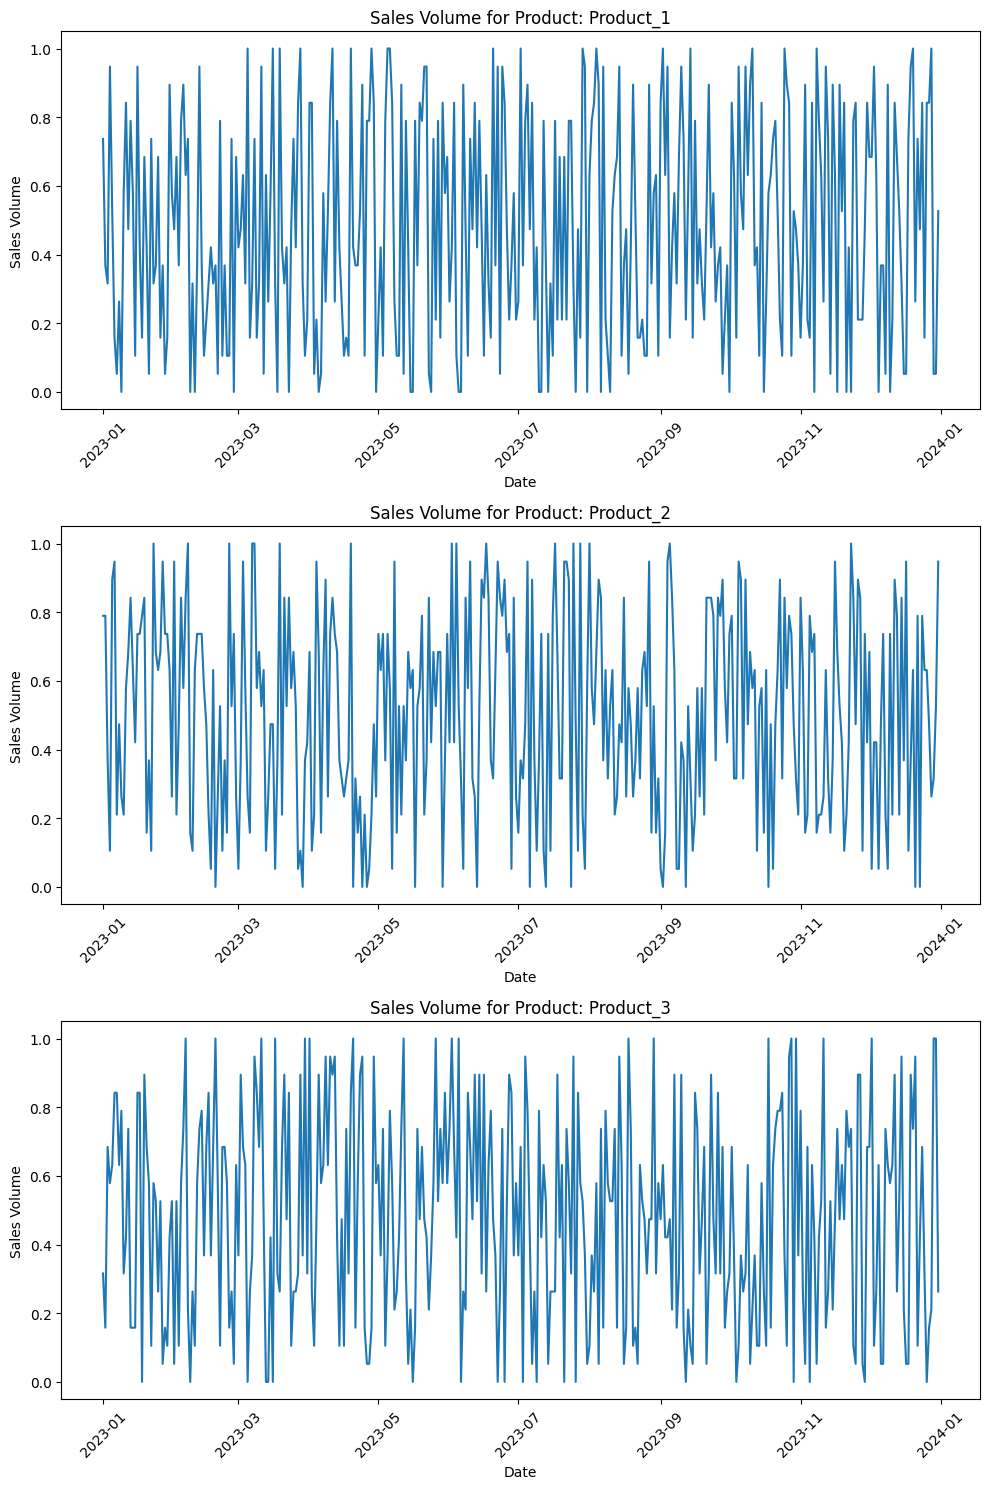

In [46]:
# Create subplots-
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through products and create plots
for i, (product, group) in enumerate(products):
    axes[i].plot(group['Date'], group['Sales_Volume'])
    axes[i].set_title(f'Sales Volume for Product: {product}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales Volume')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

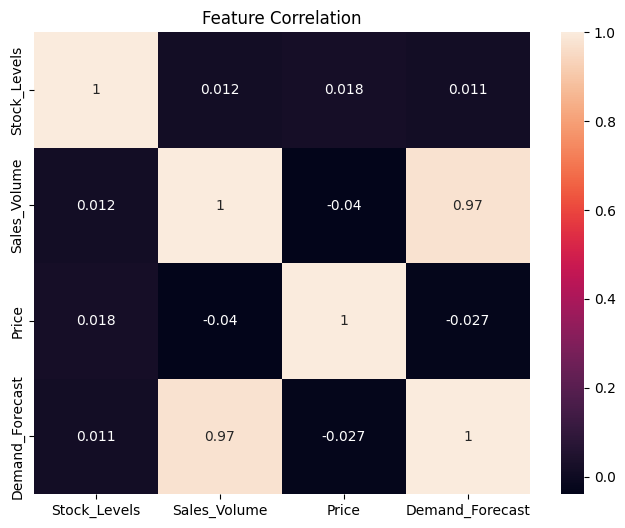

In [47]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Stock_Levels', 'Sales_Volume', 'Price', 'Demand_Forecast']].corr(), annot=True)
plt.title('Feature Correlation')
plt.show()

In [48]:
# LSTM for Demand Forecasting-
def prepare_lstm_data(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [49]:
product_data = df[df['Product'] == 'Product_1']
sales_data = product_data['Sales_Volume'].values

In [50]:
# Preparing LSTM Data-
time_steps = 7
X, y = prepare_lstm_data(sales_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [51]:
# Splitting data into Train and Test-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Building LSTM Model-
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
# Training the Model-
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3218 - val_loss: 0.1924
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1415 - val_loss: 0.1214
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1151 - val_loss: 0.1173
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1097 - val_loss: 0.1147
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1075 - val_loss: 0.1140
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1010 - val_loss: 0.1117
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1053 - val_loss: 0.1129
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0964 - val_loss: 0.1097
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1087 - val_loss: 0.1097
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1041 - val_loss: 0.1088
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1120 - val_loss: 0.1085
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1031 - 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


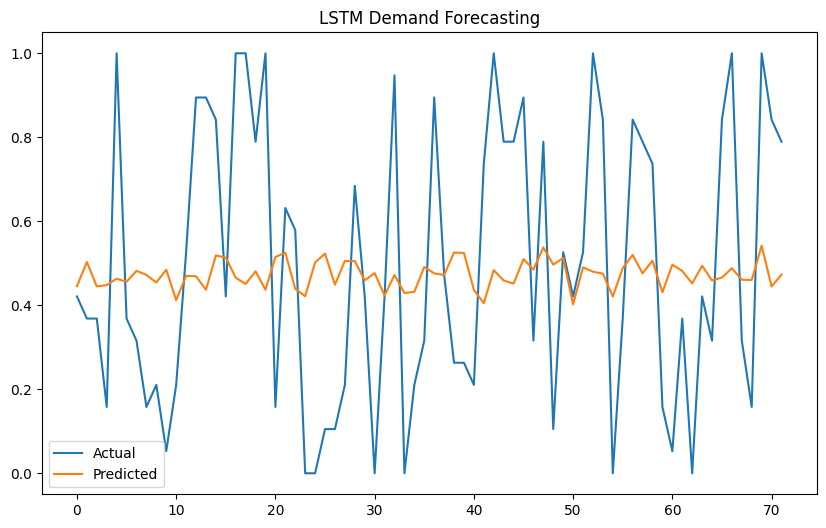

In [54]:
# Prediction and Visualization-
y_pred = lstm_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Demand Forecasting')
plt.show()